In [1]:
%load_ext autoreload
%autoreload 1

In [21]:
(mnist['training_images'].reshape(-1,50,28,28)/255).max()

1.0

In [32]:
import numpy as np
from NeuralNetwork import NeuralNetwork, sigmoid
from Dense import Dense, Reshape
from Conv import Conv
from Tensor import Tensor
import matplotlib.pyplot as plt
import pyopencl as cl
import pickle
from IPython.display import clear_output
mnist = pickle.load(open('mnist.pkl','rb'))

x_train, y_train = Tensor(mnist['training_images'].reshape(-1,50,28,28)/255), Tensor(np.array([[0]*i+[1]+[0]*(9-i) for i in mnist['training_labels']]))

model = NeuralNetwork([Conv((14,14),3,0,(1,1),sigmoid,inputShape=(28,28,1)),Conv((10,10),9,0,(1,1),sigmoid), Reshape(-1), Dense(10, sigmoid)])
def plotfunc(loss):
    if len(loss) % 100 == 0:
        plt.plot(loss[100:])
        plt.pause(0.1)
        clear_output(wait=True)

model.train(x_train, y_train, epochs=50, lrate=0.01, plotfunc=plotfunc)

KeyboardInterrupt: 

12 10


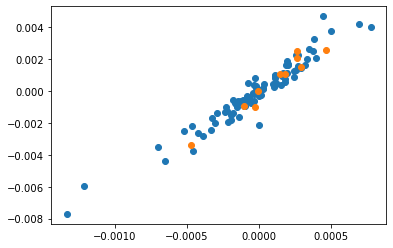

In [3]:
import numpy as np
from NeuralNetwork import NeuralNetwork, sigmoid
from Dense import Dense, Reshape
from Conv import Conv
from Tensor import Tensor
import matplotlib.pyplot as plt
import pyopencl as cl

model = NeuralNetwork([Conv((3,3),10,0,(1,1),sigmoid, inputShape=(6,6,1)),Conv((3,3),3,0,(1,1),sigmoid),Reshape(-1),Dense(10,sigmoid)])
model.allocateMemory(1)
x = Tensor(np.random.randn(*(1,*model.inputShape)))
y = Tensor(np.random.randn(1,*model.outputShape))
model.gradientDescent(x,y,0)
dw,db = model.testGrads(x,y)

l = 0
plt.scatter(dw[l],model.layers[l].dw.get().flatten())
plt.scatter(db[l],model.layers[l].db.get().flatten())

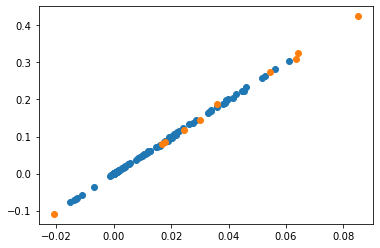

In [ ]:
l = 3
plt.scatter(dw[l],model.layers[l].dw.get().flatten())
plt.scatter(db[l],model.layers[l].db.get().flatten())